# Backtest weekly stock price reversal trading strategy

- Contrarian strategy (Lo and Mackinlay 1990, and others), statistical arbitrage
- implementation shortfall, structural change with unknown breakpoint

Copyright 2023, Terence Lim

MIT License

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series, to_datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
from finds.database import SQL, Redis
from finds.busday import BusDay, WeeklyDay
from finds.structured import CRSP, Benchmarks
from finds.recipes import fractiles, lm
from finds.display import row_formatted, show
from conf import credentials, VERBOSE, paths

%matplotlib inline
VERBOSE = 0
SHOW = dict(ndigits=4, latex=None)

endweek = 20220330
sql = SQL(**credentials['sql'], verbose=VERBOSE)
rdb = Redis(**credentials['redis'])
bd = BusDay(sql, verbose=VERBOSE)
crsp = CRSP(sql, bd, rdb=rdb, verbose=VERBOSE)
bench = Benchmarks(sql, bd)
imgdir = paths['images']

## Construct weekly reversal

In [2]:
begweek = 19740102   # increased stocks coverage in CRSP in Jan 1973
middate = 19851231   # increased stocks traded in CRSP around this date
wd = WeeklyDay(sql, bd(endweek).strftime('%A'))   # Generate weekly cal
rebaldates = wd.date_range(begweek, endweek)
retdates = wd.date_tuples(rebaldates)

Last FamaFrench Date 2022-11-30 00:00:00


### Retrieve weekly returns, standardize scores, and compute returns and i.c.

2516it [01:02, 40.26it/s]


,mean,std
"Alpha, IC and Vol of Weekly Mean Reversion Strategy",,
ic,0.0372,0.1239
vol,0.0443,0.0174
ret,0.0017,0.0080


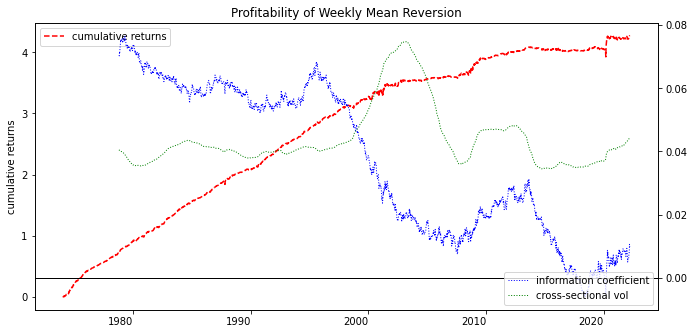

In [3]:
june_universe = 0  # to track when reached a June end to update universe
year = 0           # to track new year to retrieve prices in batch
results = []
lagged_exposures = Series(dtype=float)   # for "turnover" of stock weights

for rebaldate, pastdates, nextdates in tqdm(zip(rebaldates[1:-1],
                                                retdates[:-1],
                                                retdates[1:])):
    # screen by June universe
    d = bd.june_universe(rebaldate)
    if d != june_universe:  # need next June's universe
        june_universe = d                        # update universe every June
        univ = crsp.get_universe(june_universe)  # usual CRSP universe screen
        univ = univ[univ['decile'] <= 5]         # drop smallest half stocks

    # retrieve new batch of prices when start each year        
    if bd.begyr(rebaldate) != year:
        year = bd.begyr(rebaldate)
        prc = crsp.get_range(dataset='daily',
                             fields=['bidlo', 'askhi', 'prc', 'retx', 'ret'],
                             date_field='date',
                             beg=year,
                             end=bd.offset(bd.endyr(year), 10),
                             cache_mode="rw")

    # get past week's returns, require price at start of week
    past_week = prc[prc.index.get_level_values('date') == rebaldate]['prc']\
        .reset_index()\
        .set_index('permno')\
        .join(crsp.get_ret(*pastdates).reindex(univ.index))\
        .dropna()

    # convert past week's contrarian returns to standardized exposures
    exposures = ((past_week['ret'].mean() - past_week['ret']) /
                 (past_week['ret'].std(ddof=0) * len(past_week)))

    # turnover is abs change in stock weight, scaled by total abs weight
    delta = pd.concat([exposures, -lagged_exposures], axis=1)\
              .fillna(0)\
              .sum(axis=1)\
              .abs()\
              .sum()\
              / (exposures.abs().sum() + lagged_exposures.abs().sum())
    lagged_exposures = exposures
    
    # get next week's returns
    next_week = crsp.get_ret(*nextdates).reindex(past_week.index).fillna(0)

    # get next day's prices, to compute one-day delay cost
    next_day = prc[prc.index.get_level_values('date')==bd.offset(rebaldate, 1)]\
        .reset_index()\
        .set_index('permno')\
        .drop(columns='date')\
        .reindex(past_week.index)
    avgprc = next_day[['bidlo', 'askhi', 'prc']].abs().mean(axis=1)

    # if no trade next day, then enter at askhi (long) or bidlo (short)
    bidask = next_day['askhi'].where(exposures > 0, next_day['bidlo']).abs()
    avgprc = next_day['prc'].where(next_day['prc'] > 0, bidask)

    # drift to next's day price => delay cost is -drift * exposure
    drift = (avgprc.div(next_day['prc'].abs())\
             .mul(1 + next_day['ret']) - 1).fillna(0.)

    # accumulate weekly computations
    results.append(DataFrame({'ret': exposures.dot(next_week),
                              'ic': exposures.corr(next_week),
                              'n': len(next_week),
                              'beg': nextdates[0],
                              'end': nextdates[1],
                              'absweight': np.sum(exposures.abs()),
                              'turnover': delta,
                              'vol': next_week.std(ddof=0),
                              'delay': exposures.dot(-drift)},
                             index=[rebaldate]))

# Combine accumulated weekly computations
df = pd.concat(results, axis=0)
dates = df.index

# Plot returns, i.c. and cross-sectional vol over time
fig, ax = plt.subplots(num=1, clear=True, figsize=(10, 5))
df.index = pd.DatetimeIndex(df.index.astype(str))
df['ret'].cumsum().plot(ax=ax, ls='--', color='r', rot=0)
ax.legend(['cumulative returns'], loc='upper left')
ax.set_ylabel('cumulative returns')

bx = ax.twinx()
df['ic'].rolling(250).mean().plot(ax=bx, ls=':', lw=1, rot=0, color='b')
df['vol'].rolling(250).mean().plot(ax=bx, ls=':', lw=1, rot=0, color='g')
#bx.axhline(df['ic'].mean(), linestyle='-', color='C0', lw=2)
bx.axhline(0, linestyle='-', color='black', lw=1)
bx.legend(['information coefficient', 'cross-sectional vol'], loc='lower right')
ax.set_title('Profitability of Weekly Mean Reversion')
plt.tight_layout(pad=2)
plt.savefig(imgdir / 'weekrev.jpg')

show(pd.concat([df[['ic' ,'vol', 'ret']].mean(axis=0).rename('mean'),
                df[['ic' ,'vol', 'ret']].std(axis=0).rename('std')],
               axis=1),
     caption=f'Alpha, IC and Vol of Weekly Mean Reversion Strategy', **SHOW)

## Structural Break Test with Unknown Date

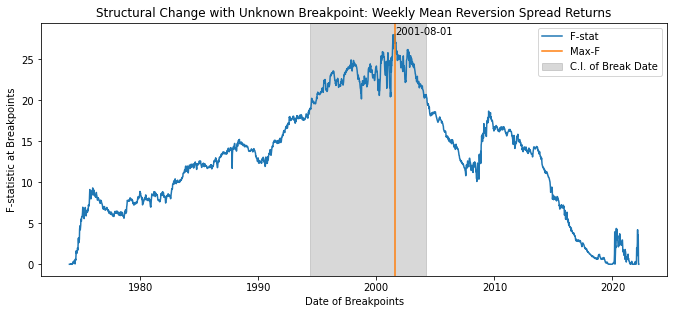

In [4]:
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from finds.pyR import PyR
importr('strucchange')   # R package to use

# Set up data and formulas for R
Y = df['ret']
#dates = to_datetime(df.index.astype(str))
formula = ro.Formula('y ~ 1')
formula.environment['y'] = PyR(Y.values).ro

# Call R strucchange routines to compute breakpoint statistics
fstats_r = ro.r['Fstats'](formula, **{'from': 1})    # Fstats at every break
breakpoints_r = ro.r['breakpoints'](formula)         # candidate breakpoints
confint_r = ro.r['confint'](breakpoints_r, breaks=1) # conf interval for 1 break
sctest_r = ro.r['sctest'](fstats_r, **{'type': 'aveF'})

# Extract output from R results
confint = PyR(confint_r[0]).frame.iloc[0].astype(int) - 1  # R index starts at 1
output = dict(zip(confint.index, df.index[confint]))       # confidence interval
for k,v in zip(sctest_r.slots['names'][:3], sctest_r[:3]): # significance values
    output[k] = PyR(v).values[0]
output['mean(pre)'] = Y[df.index <= output['breakpoints']].mean() 
output['mean(post)'] = Y[df.index > output['breakpoints']].mean()
fstat = [0] + list(PyR(fstats_r[0]).values) + [0, 0]  # pad beyond from and to 

# Plot breakpoint F-stats
fig, ax = plt.subplots(num=2, clear=True, figsize=(10, 5))
ax.plot(df.index, fstat, color='C0')
arg = np.nanargmax(fstat)
ax.axvline(df.index[arg], color='C1')
ax.axvspan(df.index[confint[0]], df.index[confint[2]], alpha=0.3, color='grey')
ax.legend(['F-stat', 'Max-F', 'C.I. of Break Date'])
ax.annotate(df.index[arg].strftime('%Y-%m-%d'), xy=(df.index[arg], fstat[arg]))
ax.set_ylabel('F-statistic at Breakpoints')
ax.set_xlabel('Date of Breakpoints')
ax.set_title('Structural Change with Unknown Breakpoint: '
             'Weekly Mean Reversion Spread Returns')
plt.tight_layout(pad=3)
plt.savefig(imgdir / 'break.jpg')

## Compute delay slippage and performance measures

In [5]:
market = bench.get_series(permnos=['Mkt-RF'], field='ret').reset_index()
breakpoint = BusDay.to_date(output['breakpoints'])
out = dict()
for period, select in enumerate([dates > 0,
                                 dates > breakpoint,
                                 dates <= breakpoint,
                                 (dates > middate) & (dates <= breakpoint),
                                 dates <= middate]):
    res = df[select].copy()
    res.index = dates[select]

    # align market returns and compute market regression beta
    #res['date'] = res.index
    res['mkt'] = [(1 + market[market['date'].between(*dt)]['Mkt-RF']).prod() - 1
                  for dt in res[['beg','end']].itertuples(index=False)]
    model = lm(res['mkt'], res['ret'], flatten=True)
    
    # save df summary
    out[f"Period {period}"] = {
        'start date': min(res.index),
        'end date': max(res.index),
        'Sharpe Ratio': np.sqrt(52)*res['ret'].mean()/res['ret'].std(),
        'Average Return': res['ret'].mean(),
        'Std Dev Return': res['ret'].std(),
        'Market Beta': model.coefficients[1],
        'Jensen Alpha (annualized)': model.coefficients[0] * 52,
        'Appraisal Ratio': np.sqrt(52) * model.coefficients[0] / model.stderr,
        'Information Coefficient': res['ic'].mean(),
        'Cross-sectional Vol': res['vol'].mean(),
        'Delay cost': res['delay'].mean(),
        'Turnover Fraction': res['turnover'].mean(),
        #'Abs Weight': res['absweight'].mean(),
        'Num Stocks': int(res['n'].mean()),
    }

# Display as formatted DataFrame
formats = dict.fromkeys(['start date' ,'end date', 'Num Stocks'], '{:.0f}')
show(row_formatted(DataFrame(out), formats=formats, default='{:.4f}'),
     caption="Subperiod Performance of Weekly Mean Reversion Strategy", **SHOW)

,Period 0,Period 1,Period 2,Period 3,Period 4
Subperiod Performance of Weekly Mean Reversion Strategy,,,,,
start date,19740109,20010808,19740109,19860108,19740109
end date,20220323,20220323,20010801,20010801,19851231
Sharpe Ratio,1.5271,0.5427,2.7053,2.0848,4.5409
Average Return,0.0017,0.0007,0.0024,0.0022,0.0027
Std Dev Return,0.0080,0.0096,0.0065,0.0077,0.0042
Market Beta,0.0877,0.1134,0.0655,0.0771,0.0496
Jensen Alpha (annualized),0.0810,0.0272,0.1211,0.1095,0.1357
Appraisal Ratio,1.4494,0.4086,2.6697,2.0120,4.6081
Information Coefficient,0.0372,0.0119,0.0562,0.0492,0.0652
